<a href="https://colab.research.google.com/github/Andrea039/prueba1/blob/master/Gatos2_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

**Define Constants**

In [2]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
PATH_DATATRAIN ="../content/drive/My Drive/Gatos2/"

**Prepare Traning Data**

In [3]:
filenames = os.listdir(PATH_DATATRAIN)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'catesfinge':
        categories.append(0)
    elif category == 'catsiames':
        categories.append(1)
    elif category == 'catorange':
        categories.append(2)
    elif category == 'catsmok':
        categories.append(3)
    else:
        categories.append(4)
        
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [4]:
df.head(15)

,filename,category
0,catesfinge.01.jpg,0
1,catesfinge.02.jpg,0
2,catesmok.01.jpg,4
3,catsangora.02.jpg,4
4,catsiames.02.jpg,1
5,catorange.01.jpg,2
6,catsmok.02.jpg,3
7,catsiames.01.jpg,1
8,catsangora.01.jpg,4
9,catorange.02.jpg,2


In [5]:
df.tail()

,filename,category
5,catorange.01.jpg,2
6,catsmok.02.jpg,3
7,catsiames.01.jpg,1
8,catsangora.01.jpg,4
9,catorange.02.jpg,2


**See Total In count**

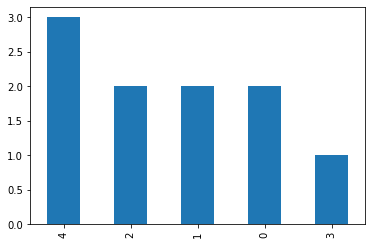

In [6]:
df['category'].value_counts().plot.bar()

**See sample image**

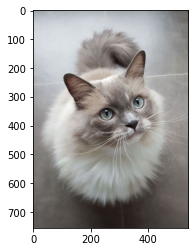

In [7]:
sample = random.choice(filenames)
image = load_img(PATH_DATATRAIN+ sample)
plt.imshow(image)

**Build Model**

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 64)       

**Callbacks**


In [11]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

**Early Stop**

In [12]:
earlystop = EarlyStopping(patience=10)

**Learning Rate Reduction**

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accurary', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [14]:
callbacks = [earlystop, learning_rate_reduction]

**Prepare Data**

In [15]:
df["category"] = df["category"].replace({0: 'catesfinge', 1: 'catsiames', 2: 'catorange', 3:'catsmok', 4:'catangora' }) 

In [16]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

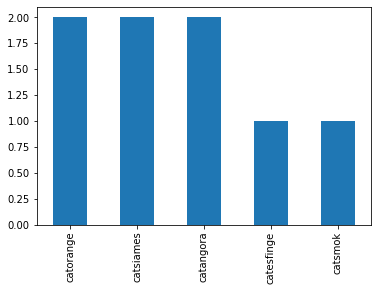

In [17]:
train_df['category'].value_counts().plot.bar()

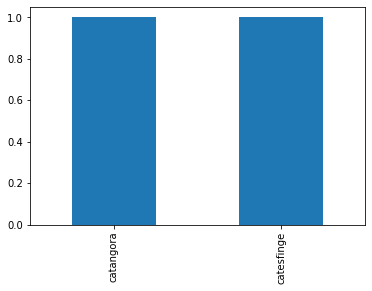

In [18]:
validate_df['category'].value_counts().plot.bar()

In [34]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=5

**Traning Generator**

In [35]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    PATH_DATATRAIN,
    x_col='filename', 
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    #clases = {'catesfinge','catsiames', 'catorange', 'catsmok', 'catangora'}, 
    batch_size=batch_size
)

Found 8 validated image filenames belonging to 5 classes.


**Validation Generator**

In [36]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    PATH_DATATRAIN , 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 2 validated image filenames belonging to 2 classes.


**See how our generator work**

In [37]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    PATH_DATATRAIN , 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


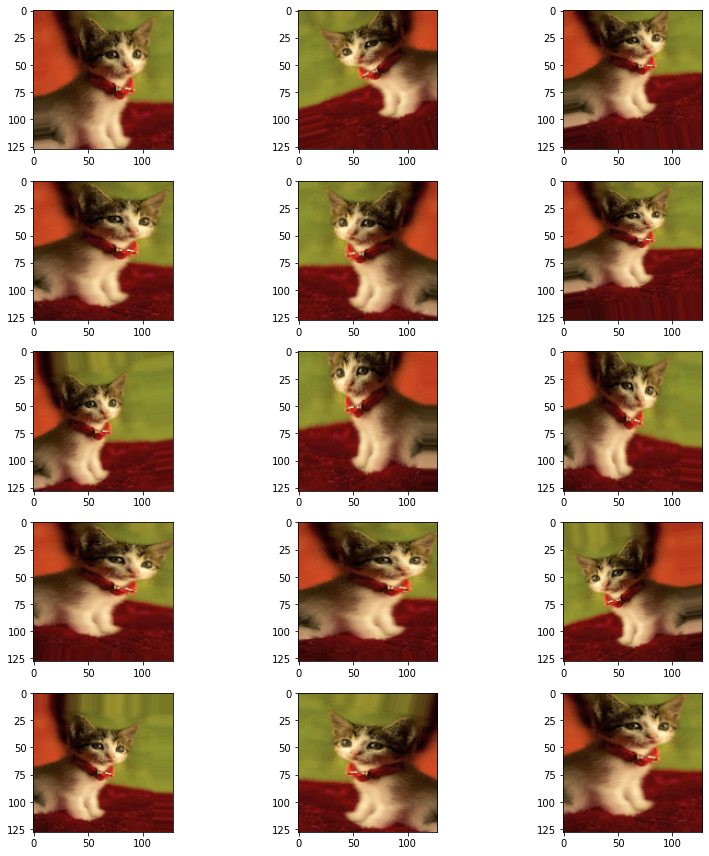

In [38]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

**Fit Model**

In [39]:
epochs=1 if FAST_RUN else 5
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size, 
    callbacks=callbacks
)

Epoch 1/5
1/1 [==============================] - 0s 61ms/step - loss: 2.3004 - accuracy: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 0s 27ms/step - loss: 3.3215 - accuracy: 0.3333
Epoch 3/5
1/1 [==============================] - 0s 25ms/step - loss: 4.3449 - accuracy: 0.3333
Epoch 4/5
1/1 [==============================] - 0s 27ms/step - loss: 2.3024 - accuracy: 0.2000
Epoch 5/5
1/1 [==============================] - 0s 25ms/step - loss: 1.2919 - accuracy: 0.3333


**Save Model**

In [45]:
model.save_weights("model.h5")
model.save_weights("model.weights.h5")
model_json = model.to_json()
with open ("model.json","w") as json_file:
  json_file.write(model_json)



KeyError: ignored

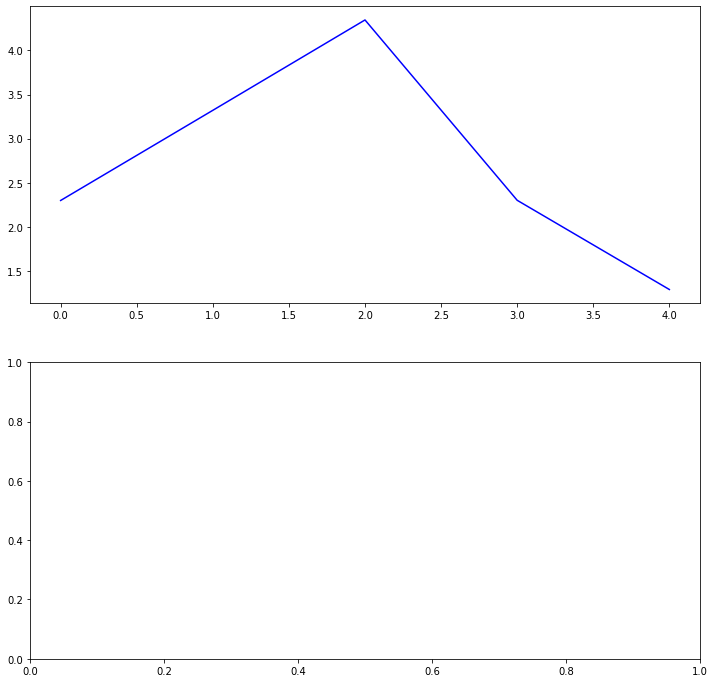

In [42]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

**Prepare Testing Data**

In [44]:
test_filenames = os.listdir("../content/drive/My Drive/petimages")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

**Create Testing Generator**

In [46]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "../content/drive/My Drive/petimages", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

KeyError: ignored

**Predict**

In [47]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

NameError: ignored

In [48]:
test_df['category'] = np.argmax(predict, axis=-1)

NameError: ignored

In [49]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)


KeyError: ignored

In [50]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

KeyError: ignored

**Virtualize Result**

In [51]:
test_df['category'].value_counts().plot.bar()

KeyError: ignored

**See predicted result with images**

In [53]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("../input/test1/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

<Figure size 864x1728 with 0 Axes>

**Submission**

In [54]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)

AttributeError: ignored